In [1]:
import pandas as pd
import numpy as np
from math import log
from random import sample
import os
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('train.csv')
train['target'] = train['target'] == 'recurrence-events'
test = pd.read_csv('test.csv')
test['target'] = test['target'] == 'recurrence-events'
attributes = ['age', 'menopause', ' tumor_size', 'inv_nodes', 'node_caps', 'deg_malig', 'breast', 'breast_quad', 'irradiant']
train['deg_malig']=train['deg_malig'].astype(str)
test['deg_malig']=test['deg_malig'].astype(str)
train.head()

,target,age,menopause,tumor_size,inv_nodes,node_caps,deg_malig,breast,breast_quad,irradiant
0,False,50-59,ge40,0-4,0-2,no,2,left,central,no
1,False,30-39,premeno,30-34,6-8,yes,2,right,right_up,no
2,False,40-49,premeno,30-34,0-2,no,3,left,left_up,no
3,False,50-59,ge40,25-29,0-2,no,3,left,right_up,no
4,True,50-59,premeno,30-34,0-2,no,3,left,right_up,no


In [3]:
class_dict = {'age':["10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80-89", "90-99"],
              'menopause':["lt40", "ge40", "premeno"],
              ' tumor_size':["0-4", "5-9", "10-14", "15-19", "20-24", "25-29", "30-34", "35-39", "40-44", "45-49", "50-54", "55-59"],
              'inv_nodes':["0-2", "3-5", "6-8", "9-11", "12-14", "15-17", "18-20", "21-23", "24-26", "27-29", "30-32", "33-35", "36-39"],
              'node_caps':["yes", "no"],
              'deg_malig':["1", "2", "3"],
              'breast':["left", "right"],
              'breast_quad':[ "left_up", "left_low", "right_up", "right_low", "central"],
              'irradiant':["yes", "no"]}

In [4]:
def train_error(a):
    return min(a,1-a)

def gini(a):
    return 2*a*(1-a)

def entropy(a):
    entropy = 0
    if a > 0 and a<1:
        entropy = -a*log(a,2) - (1-a)*log(1-a,2)
    return entropy

def max_gain_feature(data, features, k, gain_measure):
    max_gain = -100
    max_gain_feature = None

    if len(features)>k:
        features = sample(features,k)
    
    for feature in features:
        gain = gain_measure(data['target'].mean())
        for value in np.unique(data[feature]):
            data_sample = data[data[feature]==value]
            p = np.sum(data_sample['target'])/len(data_sample)
            gain -= (len(data_sample)/len(data))*gain_measure(p)
        gain = np.round(gain,10)
        if gain >= max_gain:
            max_gain = gain
            max_gain_feature = feature
    return max_gain_feature

def mayority_labels(data):
    if data['target'].mean()>=0.5:
        return 1
    else:
        return 0

def predict(tree, X):
    y_predict = np.zeros(len(X))
    for i, row in X.iterrows():
        pred_tree = tree
        while 'label' not in pred_tree:
            attribute = pred_tree['attribute']
            next_node = row[attribute]
            pred_tree = pred_tree['nodes'][next_node]
        y_predict[i] = pred_tree['label']
    return y_predict

def id3(leaf_data, remaining_features, k, max_depht, node_depht, gain_measure):
    node = {}
    node['depht'] = node_depht
    
    data_labels = np.unique(leaf_data['target'])
    if len(data_labels)==1:
        node['label'] = data_labels[0]*1.0
        return node
        
    if len(remaining_features)==0:
        node['label'] = mayority_labels(leaf_data)
        return node
        
    max_feature = max_gain_feature(leaf_data, remaining_features, k, gain_measure)

    node['attribute'] = max_feature
    node['nodes'] = {}
    
    next_features = list(remaining_features)
    next_features.remove(max_feature)
    
    for value in class_dict[max_feature]:
        next_leaf_data = leaf_data[leaf_data[max_feature]==value].copy()
        if len(next_leaf_data)==0:
            node['nodes'][value] = {'label': mayority_labels(leaf_data)}
        elif node_depht==max_depht:
            node['nodes'][value] = {'label': mayority_labels(next_leaf_data)}
        else:
            node['nodes'][value] = id3(next_leaf_data, next_features, k, max_depht, node_depht+1, gain_measure)
    return node

In [5]:
def eval_model(train, test, max_depth):
    model = id3(leaf_data=train, remaining_features=attributes, k=15, max_depht=max_depth, node_depht=1, gain_measure=gini)
    train_acc = np.mean(predict(model, train[attributes])==train['target'])
    test_acc = np.mean(predict(model, test[attributes])==test['target'])
    return train_acc, test_acc

# A)

In [6]:
np.random.seed(100)
train = train.sample(frac=1).reset_index(drop=True)

In [7]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=3)
kf.get_n_splits(train)

trains = np.zeros((5,3))
vals = np.zeros((5,3))
max_ds = [1, 3, 5, 7, 9]
for i, depth in enumerate(max_ds):
    for j, idx in enumerate(kf.split(train)):
        train_s = train.iloc[idx[0],:].reset_index(drop=True)
        test_s = train.iloc[idx[1], :].reset_index(drop=True)
        train_i, test_i = eval_model(train_s, test_s, depth)
        trains[i,j] = train_i
        vals[i,j] = test_i

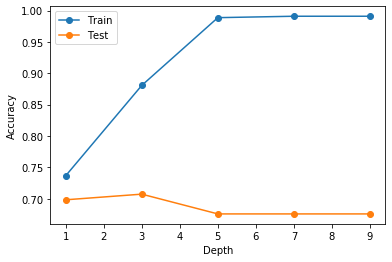

In [8]:
plt.plot(max_ds, np.mean(trains, axis=1), marker='o', label='Train')
plt.plot(max_ds, np.mean(vals, axis=1), marker='o', label='Test')
plt.ylabel('Accuracy')
plt.xlabel('Depth')
plt.legend()

# B)

In [9]:
train_best, test_best = eval_model(train, test, 3)
print('Train accuracy: ',train_best)
print('Test accuracy: ',test_best)

Train accuracy:  0.8558558558558559
Test accuracy:  0.6545454545454545


# C)

The train accuracy increases with the max depth because the model is more complex. Validation accuracy decreases after a max depth of 3 since the model began to overfit to the training data, increasing the generalization error.
